# 파트 7: 최소 지식 베이스

파트 1-6에서는 완전한 에이전틱 추론 기능을 가진 지식 베이스를 사용했습니다. 파트 7에서는 일부 추론 정교함을 속도와 비용의 상당한 개선과 교환하는 **최소 추론 노력** 최적화를 살펴봅니다. 이 접근 방식은 더 간단한 쿼리에 대해 빠르고 비용 효율적인 검색이 필요할 때 이상적입니다.

## 단계 1: 환경 변수 로드

아래 셀을 실행하여 Azure 리소스의 구성을 로드하고, 생성된 **.venv(3.11.9)** 환경을 선택하세요.

이번에는 최소 추론 노력에 최적화된 지식 베이스를 생성합니다.

> **⚠️ 문제 해결**
>
> 코드 셀이 멈추고 계속 돌아가면 노트북 상단 툴바에서 **Restart**를 선택하세요. 몇 번 시도해도 문제가 지속되면 VS Code를 완전히 닫고 다시 여세요.

In [1]:
import os

from azure.core.credentials import AzureKeyCredential
from dotenv import load_dotenv

load_dotenv(override=True) # take environment variables from .env.

# Azure AI Search configuration
endpoint = os.environ["AZURE_SEARCH_SERVICE_ENDPOINT"]
credential = AzureKeyCredential(os.environ["AZURE_SEARCH_ADMIN_KEY"])

# Knowledge base name
knowledge_base_name = "minimal-knowledge-base"

# Azure OpenAI configuration
azure_openai_endpoint = os.environ["AZURE_OPENAI_ENDPOINT"]
azure_openai_key = os.environ["AZURE_OPENAI_KEY"]
azure_openai_chatgpt_deployment = os.getenv("AZURE_OPENAI_CHATGPT_DEPLOYMENT", "gpt-4.1")
azure_openai_chatgpt_model_name = os.getenv("AZURE_OPENAI_CHATGPT_MODEL_NAME", "gpt-4.1")

print("Environment variables loaded")

Environment variables loaded


## 단계 2: 최소 추론 지식 베이스 생성

`KnowledgeRetrievalMinimalReasoningEffort`를 사용하여 속도와 비용에 최적화된 지식 베이스를 생성합니다.

이전 파트와 두 가지 주요 차이점을 확인하세요:

1. **Azure OpenAI 모델 구성 없음**: 지식 베이스가 LLM 기반 쿼리 계획 및 답변 합성을 건너뜁니다
2. **`EXTRACTIVE_DATA` 출력 모드**: 합성된 답변 대신 원시 청크를 반환합니다

이 구성은 정교한 추론 기능보다 속도와 비용 절감을 우선시합니다.

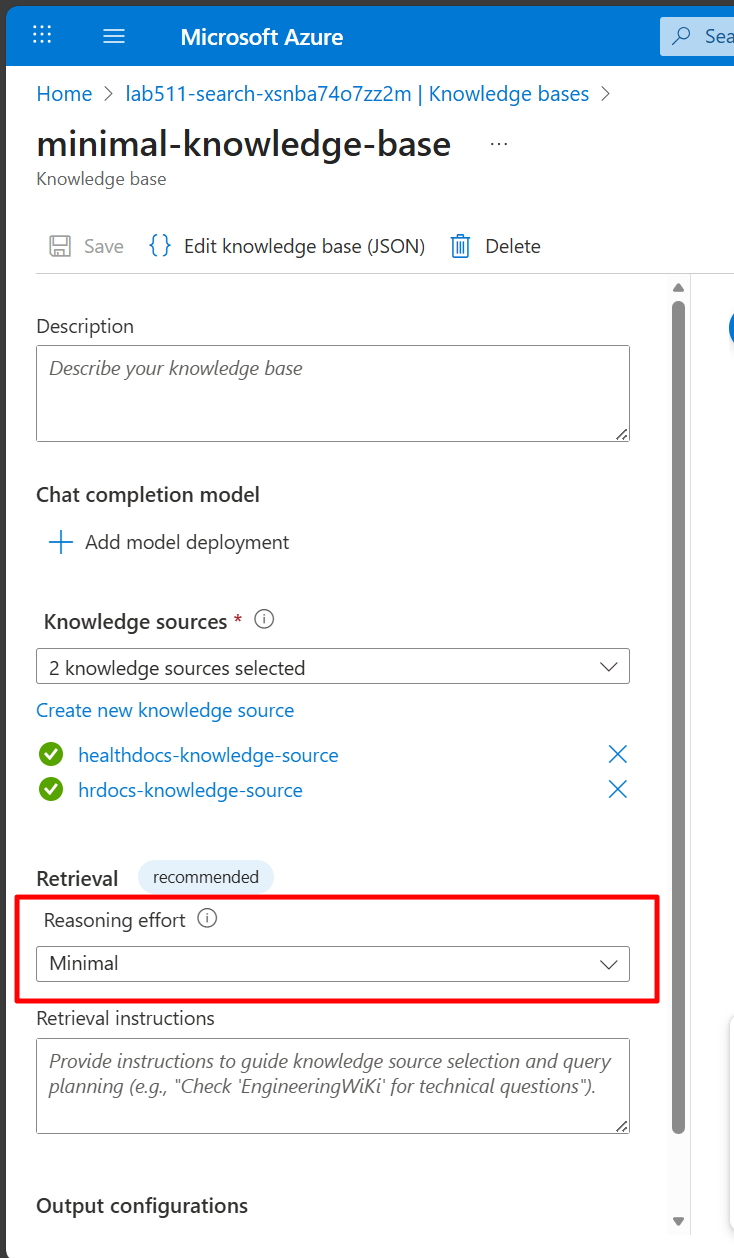

In [2]:
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.indexes.models import KnowledgeBase, KnowledgeRetrievalMinimalReasoningEffort, KnowledgeRetrievalOutputMode, KnowledgeSourceReference

index_client = SearchIndexClient(endpoint=endpoint, credential=credential)

knowledge_base = KnowledgeBase(
    name=knowledge_base_name,
    knowledge_sources=[
        KnowledgeSourceReference(name="healthdocs-knowledge-source"),
        KnowledgeSourceReference(name="hrdocs-knowledge-source"),
    ],
    output_mode=KnowledgeRetrievalOutputMode.EXTRACTIVE_DATA,
    retrieval_reasoning_effort=KnowledgeRetrievalMinimalReasoningEffort()
)

index_client.create_or_update_knowledge_base(knowledge_base)
print(f"Knowledge base '{knowledge_base_name}' created or updated successfully.")

Knowledge base 'minimal-knowledge-base' created or updated successfully.


## 단계 3: 시맨틱 인텐트로 쿼리

최소 추론 지식 베이스는 대화형 메시지 대신 `KnowledgeRetrievalSemanticIntent`를 사용합니다. 각 인텐트는 지식 소스에 대한 직접 검색 쿼리로 실행됩니다.

아래 코드는 두 개의 시맨틱 인텐트를 실행하고 참조와 활동 로그를 포함하지만 합성된 답변은 없는 결과를 반환합니다.

In [3]:
from azure.search.documents.knowledgebases import KnowledgeBaseRetrievalClient
from azure.search.documents.knowledgebases.models import KnowledgeBaseRetrievalRequest, KnowledgeRetrievalSemanticIntent, SearchIndexKnowledgeSourceParams

knowledge_base_client = KnowledgeBaseRetrievalClient(endpoint=endpoint, knowledge_base_name=knowledge_base_name, credential=credential)
healthdocs_ks_params = SearchIndexKnowledgeSourceParams(
    knowledge_source_name="healthdocs-knowledge-source",
    include_references=True,
    include_reference_source_data=True,
)
hrdocs_ks_params = SearchIndexKnowledgeSourceParams(
    knowledge_source_name="hrdocs-knowledge-source",
    include_references=True,
    include_reference_source_data=True,
)
req = KnowledgeBaseRetrievalRequest(
    intents=[
        KnowledgeRetrievalSemanticIntent(
            search="Zava CEO의 책임은 무엇인가요?"
        ),
        KnowledgeRetrievalSemanticIntent(
            search="Zava 건강 보험 플랜 중 정신 건강 서비스에 가장 적합한 보장을 원할 경우 어떤 플랜을 추천하시나요?"
        )
    ],
    knowledge_source_params=[
        healthdocs_ks_params,
        hrdocs_ks_params
    ],
    include_activity=True,
    retrieval_reasoning_effort=KnowledgeRetrievalMinimalReasoningEffort()
)
result = knowledge_base_client.retrieve(retrieval_request=req)

## 단계 4: 원시 검색 데이터 검토

최소 추론 지식 베이스의 결과에는 지식 소스에서 검색된 원시 데이터 청크가 포함됩니다. 최소 노력 베이스는 자체 LLM 질문-답변 로직이 있는 애플리케이션에 에이전틱 검색을 통합하거나 결과를 직접 표시할 때 유용합니다.

코드를 실행하고 결과를 관찰하여 최소 추론 지식 베이스가 쿼리를 어떻게 효율적으로 처리하는지 확인하세요.

In [4]:
import json

references = json.dumps([ref.as_dict() for ref in result.references], indent=2)
print(references)

[
  {
    "type": "searchIndex",
    "id": "0",
    "activity_source": 2,
    "source_data": {
      "uid": "810256edf976_aHR0cHM6Ly9tYWdvdHRlaWFkbHNnZW4yLmJsb2IuY29yZS53aW5kb3dzLm5ldC9sYWJkb2NzL3JvbGVfbGlicmFyeS5wZGY1_pages_1",
      "blob_path": "/hrdocs/role_library.pdf",
      "snippet": "\u2022 Bachelor\u2019s degree in business or related field \n\n\u2022 10+ years of experience in executive management \n\n\u2022 Proven success in leading and managing a team \n\n\u2022 Strong problem-solving and analytical skills \n\n\u2022 Excellent communication and interpersonal skills \n\n\u2022 Ability to make strategic decisions \n\n\u2022 Knowledge of business finances \n\n\u2022 Knowledge of business operations \n\n\u2022 Knowledge of industry trends \n\n\u2022 Knowledge of applicable laws and regulations \n\n  \n\n\n\nChief Operating Officer \n\nJob Title: Chief Operating Officer \n\nCompany: Zava \n\nLocation: Any major city \n\nPosition Summary: \n\nThe Chief Operating Officer (COO) at

In [5]:
import pandas as pd

activity_types = [{"type": a.type} for a in result.activity]

df = pd.DataFrame(activity_types)

print("Activity Log Steps")
df

Activity Log Steps


,type
0,searchIndex
1,searchIndex
2,searchIndex
3,searchIndex
4,agenticReasoning


In [6]:
activity_content = json.dumps([a.as_dict() for a in result.activity], indent=2)
print("Activity Details")
print(activity_content)

Activity Details
[
  {
    "id": 0,
    "type": "searchIndex",
    "elapsed_ms": 1619,
    "knowledge_source_name": "healthdocs-knowledge-source",
    "query_time": "2026-01-22T14:19:46.144Z",
    "count": 1,
    "search_index_arguments": {
      "search": "Zava CEO\uc758 \ucc45\uc784\uc740 \ubb34\uc5c7\uc778\uac00\uc694?",
      "source_data_fields": [
        {
          "name": "snippet"
        },
        {
          "name": "uid"
        },
        {
          "name": "blob_path"
        }
      ],
      "search_fields": [
        {
          "name": "snippet"
        }
      ],
      "semantic_configuration_name": "semantic-configuration"
    }
  },
  {
    "id": 1,
    "type": "searchIndex",
    "elapsed_ms": 439,
    "knowledge_source_name": "healthdocs-knowledge-source",
    "query_time": "2026-01-22T14:19:46.594Z",
    "count": 25,
    "search_index_arguments": {
      "search": "Zava \uac74\uac15 \ubcf4\ud5d8 \ud50c\ub79c \uc911 \uc815\uc2e0 \uac74\uac15 \uc11c\ube44\uc2a4\u

## 단계 5: 합성된 답변 생성

검색된 청크에서 합성된 답변을 원한다면 처리를 위해 LLM에 전달할 수 있습니다. 아래 코드는 추출된 데이터를 사용하여 간결한 답변을 생성하는 방법을 보여줍니다.

In [7]:
from IPython.display import display, Markdown
from openai import AsyncOpenAI

openai_client = AsyncOpenAI(
    base_url=azure_openai_endpoint + "openai/v1/",
    api_key=azure_openai_key
)

response = await openai_client.responses.create(
    model=azure_openai_chatgpt_deployment,
    instructions="당신은 주어진 맥락에 따라 간결한 답변을 제공하는 유용한 조력자입니다.",
    input=f"""
    다음 맥락을 바탕으로 질문에 간결하게 답하시오.\n\nContext:\n{result.response[0].content[0].text}
    \n\n질문:\nZava CEO의 책임은 무엇인가요?
    Zava 건강 보험 플랜 중 정신 건강 서비스에 가장 적합한 보장을 원할 경우 어떤 플랜을 추천하시나요?
    """
)

display(Markdown(response.output_text))

1. Zava CEO의 책임은 무엇인가요?  
- 회사의 전략 및 목표 개발과 실행, 장기적 성장과 재무 성공 보장, 임원진 및 경영진에게 전략적 방향 제시, 일상 운영 관리, 법규 준수, 마케팅 전략 개발, 주요 이해관계자와의 관계 관리, 대외 활동에서 회사 대표, 계약 관리와 협상, 업계 동향 모니터링, 긍정적인 기업 문화 조성 등이 포함됩니다.

2. Zava 건강 보험 플랜 중 정신 건강 서비스에 가장 적합한 보장을 원할 경우 어떤 플랜을 추천하시나요?  
- Northwind Health Plus 플랜을 추천합니다. 이 플랜은 정신 건강 상담, 치료, 입원 및 외래 모든 서비스를 폭넓게 보장하며, 인네트워크(provider) 이용 시 더 낮은 본인 부담금과 더 포괄적인 보장을 받을 수 있습니다.

## 요약

이제 정교한 추론 기능보다 속도와 비용에 최적화된 최소 추론 지식 베이스를 경험했습니다.

**기억해야 할 핵심 개념:**
- `KnowledgeRetrievalMinimalReasoningEffort`는 고급 추론보다 속도와 비용 절감을 우선시합니다
- `EXTRACTIVE_DATA` 출력 모드는 합성된 답변 대신 원시 청크를 반환합니다
- `KnowledgeRetrievalSemanticIntent`는 대화형 메시지 대신 집중된 검색 인텐트로 쿼리를 구조화합니다
- 지식 베이스 구성에 Azure OpenAI 모델이 필요하지 않아 기본 비용이 줄어듭니다
- Azure OpenAI를 사용한 선택적 후처리로 LLM 합성 사용 시기를 제어할 수 있습니다

### 다음 단계

➡️ [파트 8: 중간 지식 베이스](part8-medium-knowledge-base.ipynb)로 계속하여 중간 추론 노력이 정교함과 성능의 균형을 어떻게 맞추는지 배웁니다.